In [ ]:
"""
This notebook explores the relationship between the amenities available near a home and its price.
"""

%pip install -q pandas matplotlib seaborn scikit-learn shap
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sklearn



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


doctors_count      0.031843
downtown_count    -0.118091
Entertainment     -0.015081
golf_count        -0.014934
Grocery            0.165926
hospital_count    -0.091363
hospitals_count    0.121051
Parks              0.079923
Schools            0.037194
Shopping           0.233635
University        -0.062410
Waterfront        -0.027589
Name: Prices, dtype: float64


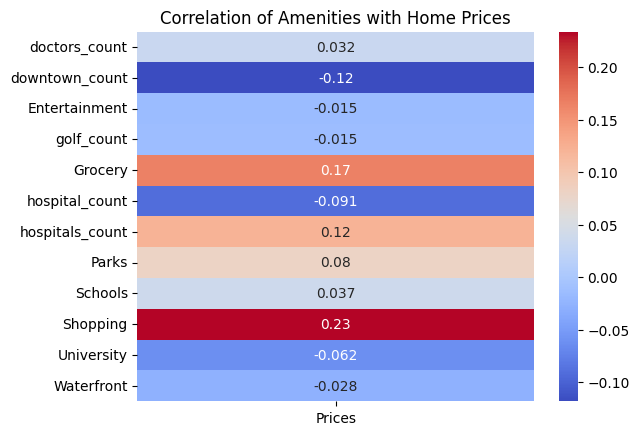

In [ ]:
# Load data into a DataFrame
df_visual = pd.read_csv('../csvs/DA_summary_counts.csv')
numeric_columns = df_visual.select_dtypes(include="number")
corr_with_price = numeric_columns.corr()['Prices'].drop('Prices').drop('DAUID')
plt.title("Correlation of Amenities with Home Prices")
sns.heatmap(corr_with_price.to_frame(), annot=True, cmap="coolwarm")

print(corr_with_price)

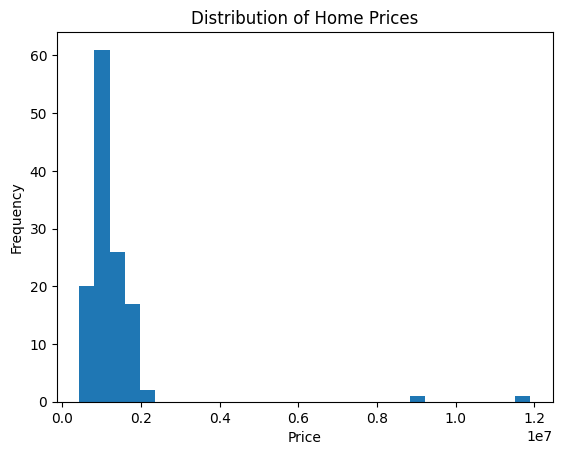

In [ ]:
from sklearn.model_selection import train_test_split, KFold
# Split the test data into training and testing sets 
df = pd.read_csv('../csvs/DA_summary_counts.csv')
x = df.drop(columns=['Residential_TotalGross_Average', 'DAUID'])
y = df['Residential_TotalGross_Average']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

plt.hist(y_train, bins=30)
plt.title("Distribution of Home Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()



In [5]:
# random forest with k-fold cross validation (very poor results)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
kf = KFold(n_splits=20, shuffle=True, random_state=42)

model = RandomForestRegressor(
    n_estimators=300,            
    random_state=42
)

mae_scores = []
rmse_scores = []
r2_scores = []
for i, (train_index, test_index) in enumerate(kf.split(x_train)):
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(x_train_fold, y_train_fold)
    predictions = np.array(model.predict(x_test_fold))

    actual = np.array(y_test_fold)
    r2_scores.append(r2_score(y_test_fold, predictions))
    mae_scores.append(mean_absolute_error(y_test_fold, predictions))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, predictions)))
    difference = predictions - y_test_fold
    print(difference)
    print(f"Fold {i+1} - R2: {r2_scores[-1]}, MAE: {mae_scores[-1]}, MSE: {rmse_scores[-1]}")







10     -35744.450000
86    -551943.693333
39    -198947.383611
134    603571.320000
53    -286124.982000
83    -245142.753333
48      86959.218000
Name: Residential_TotalGross_Average, dtype: float64
Fold 1 - R2: -0.30381673691344546, MAE: 286919.11432539683, MSE: 350371.6978377619
73    -2.834511e+04
60    -1.607337e+05
0      2.046988e+05
130    4.639266e+05
6      5.726533e+05
91     2.212735e+06
32     7.536400e+05
Name: Residential_TotalGross_Average, dtype: float64
Fold 2 - R2: -11.294727799379816, MAE: 628104.6383594103, MSE: 931655.159231541
16     151097.671944
67     -17467.419444
120   -706034.750000
122    121192.399167
58    -556889.193333
1      -18810.408214
14     -12473.204444
Name: Residential_TotalGross_Average, dtype: float64
Fold 3 - R2: -0.28893728090605997, MAE: 226280.72093537418, MSE: 347838.893120316
45     227433.803333
9       66837.481032
47     741351.051667
123    465400.730000
38    -208012.021111
137    515710.233333
87    -160862.611667
Name: Residenti

In [17]:
# Random forest classifier without cross-validation (very poor resuklts)
final_model = RandomForestRegressor(
    n_estimators=100,        
    max_depth=5,            
    min_samples_split=10,    
    min_samples_leaf=5,      
    random_state=42
)
final_model.fit(x_train, y_train)
final_predictions = np.array(final_model.predict(x_test))
final_actual = np.array(y_test)
final_r2 = r2_score(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final Model - R2: {final_r2}, MAE: {final_mae}, RMSE: {final_rmse}")

Final Model - R2: -0.3884745749199172, MAE: 298096.4965248371, RMSE: 375566.39546871826


In [64]:
# Lasso regression with cross-validation
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
print(x_train_scaled)
x_test_scaled = scaler.transform(x_test)

model = LassoCV(
    alphas=np.logspace(-6, 6, 100),
    cv=5,
    random_state=42,
    max_iter=10000,
)
loo = KFold(n_splits=128, shuffle=True, random_state=42)
mae_scores = []     
rmse_scores = []
r2_scores = []
for i, (train_index, test_index) in enumerate(loo.split(x_train_scaled)):
    x_train_fold, x_test_fold = x_train_scaled[train_index], x_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    model.fit(x_train_fold, y_train_fold)
    predictions = np.array(model.predict(x_test_fold))
    actual = np.array(y_test_fold)
    mae_scores.append(mean_absolute_error(y_test_fold, predictions))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, predictions)))
    difference = predictions - y_test_fold
    print(f'Difference: {difference}')
    print(f"Fold {i+1}, MAE: {mae_scores[-1]}, RMSE: {rmse_scores[-1]}")
print(f"best alpha: {model.alpha_}")

# Last prediction result: Fold 128 - R2: nan, MAE: 458832.90801366325, MSE: 458832.90801366325

[[ 3.46069039 -0.55328334 -0.62102825 ...  0.93108859 -0.26675868
  -0.58937969]
 [ 0.62114956 -0.55328334  0.08556389 ... -0.57751064 -0.26675868
  -0.58937969]
 [-0.79862086 -0.55328334  0.43885996 ... -0.57751064 -0.26675868
  -0.58937969]
 ...
 [-0.79862086 -0.55328334 -0.62102825 ... -0.57751064 -0.26675868
  -0.58937969]
 [-0.79862086 -0.55328334 -0.62102825 ...  2.43968782 -0.26675868
  -0.58937969]
 [-0.79862086 -0.55328334  0.08556389 ... -0.57751064 -0.26675868
   1.69669911]]
Difference: 134    608496.377953
Name: Residential_TotalGross_Average, dtype: float64
Fold 1, MAE: 608496.3779527559, RMSE: 608496.3779527559
Difference: 39   -40681.322835
Name: Residential_TotalGross_Average, dtype: float64
Fold 2, MAE: 40681.32283464563, RMSE: 40681.32283464563
Difference: 10    250352.377953
Name: Residential_TotalGross_Average, dtype: float64
Fold 3, MAE: 250352.3779527559, RMSE: 250352.3779527559
Difference: 86   -322662.299213
Name: Residential_TotalGross_Average, dtype: float64


In [62]:
model = LassoCV(
    alphas=np.logspace(-6, 6, 100),
    cv=10,
    random_state=42,
    max_iter=10000,
)

model.fit(x_train_scaled, y_train)

# Test on truly unseen data
test_predictions = model.predict(x_test_scaled)
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"Test MAE: {test_mae}")
print(f"Best alpha: {model.alpha_}")
print(f"CV Score: {model.score(x_train_scaled, y_train)}")

Test MAE: 257571.16666666666
Best alpha: 1000000.0
CV Score: 0.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [63]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
print(x_train_scaled)
x_test_scaled = scaler.transform(x_test)

model = RidgeCV(
    alphas=10,
)
loo = KFold(n_splits=128, shuffle=True, random_state=42)
mae_scores = []     
rmse_scores = []
r2_scores = []
for i, (train_index, test_index) in enumerate(loo.split(x_train_scaled)):
    x_train_fold, x_test_fold = x_train_scaled[train_index], x_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    model.fit(x_train_fold, y_train_fold)
    predictions = np.array(model.predict(x_test_fold))
    actual = np.array(y_test_fold)
    mae_scores.append(mean_absolute_error(y_test_fold, predictions))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, predictions)))
    difference = predictions - y_test_fold
    print(difference)
    print(f"Fold {i+1}, MAE: {mae_scores[-1]}, RMSE: {rmse_scores[-1]}")
print(f"best alpha: {model.alpha_}")

# Last prediction result: Fold 128 - R2: nan, MAE: 458832.90801366325, MSE: 458832.90801366325

[[ 3.46069039 -0.55328334 -0.62102825 ...  0.93108859 -0.26675868
  -0.58937969]
 [ 0.62114956 -0.55328334  0.08556389 ... -0.57751064 -0.26675868
  -0.58937969]
 [-0.79862086 -0.55328334  0.43885996 ... -0.57751064 -0.26675868
  -0.58937969]
 ...
 [-0.79862086 -0.55328334 -0.62102825 ... -0.57751064 -0.26675868
  -0.58937969]
 [-0.79862086 -0.55328334 -0.62102825 ...  2.43968782 -0.26675868
  -0.58937969]
 [-0.79862086 -0.55328334  0.08556389 ... -0.57751064 -0.26675868
   1.69669911]]
134   -25624.743052
Name: Residential_TotalGross_Average, dtype: float64
Fold 1, MAE: 25624.74305224442, RMSE: 25624.74305224442
39   -497860.802705
Name: Residential_TotalGross_Average, dtype: float64
Fold 2, MAE: 497860.80270535545, RMSE: 497860.80270535545
10    45880.94551
Name: Residential_TotalGross_Average, dtype: float64
Fold 3, MAE: 45880.94551017182, RMSE: 45880.94551017182
86   -386261.3405
Name: Residential_TotalGross_Average, dtype: float64
Fold 4, MAE: 386261.3405001927, RMSE: 386261.34050

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

In [40]:
import shap
explainer = shap.LinearExplainer(model, x_train_scaled, feature_perturbation="correlation_dependent")
shap_values = explainer.shap_values(x_test_scaled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_linear.py:206: RuntimeWarning: divide by zero encountered in matmul
  self.cov = np.matmul(np.matmul(self.avg_proj, self.cov), self.avg_proj.T)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_linear.py:206: RuntimeWarning: overflow encountered in matmul
  self.cov = np.matmul(np.matmul(self.avg_proj, self.cov), self.avg_proj.T)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_linear.py:206: RuntimeWarning: invalid value encountered in matmul
  self.cov = np.matmul(np.matmul(self.avg_proj, self.cov), self.avg_proj.T)
Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_linear.py:270: RuntimeWarning: divide by zero encountered in matmul
  coef_R_Si = np.matmul(self.coef[inds[j + 1 :]], np.mat

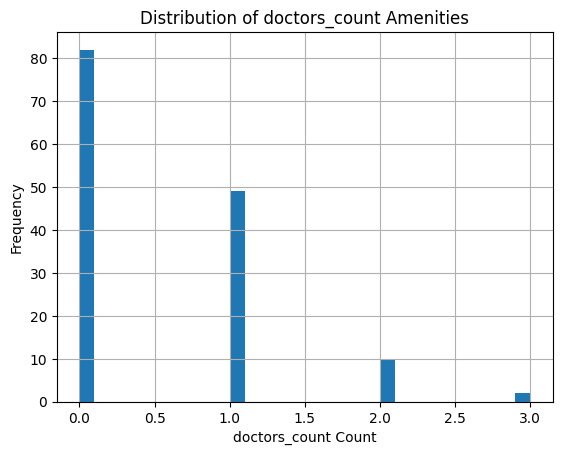

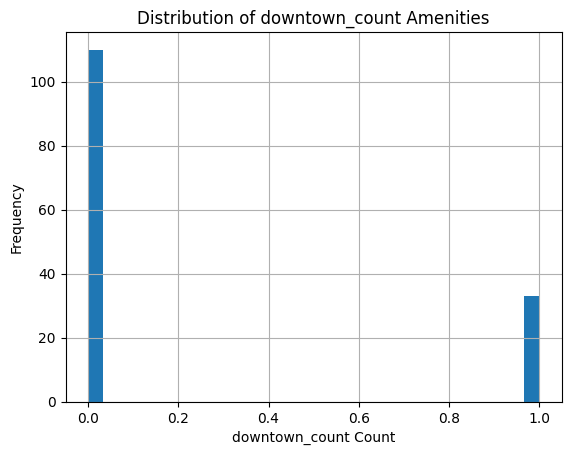

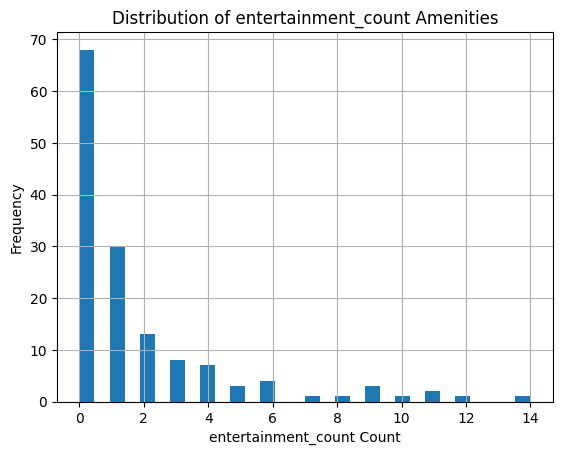

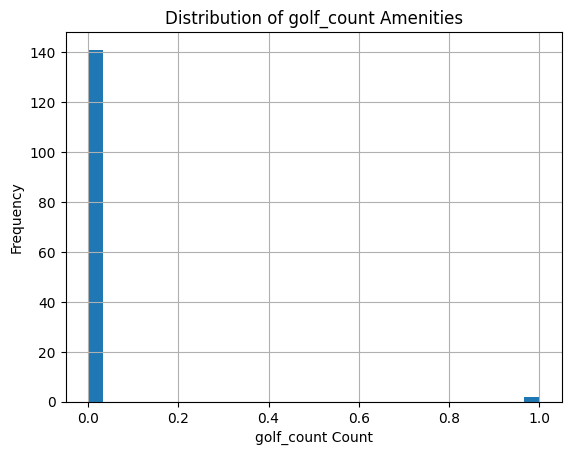

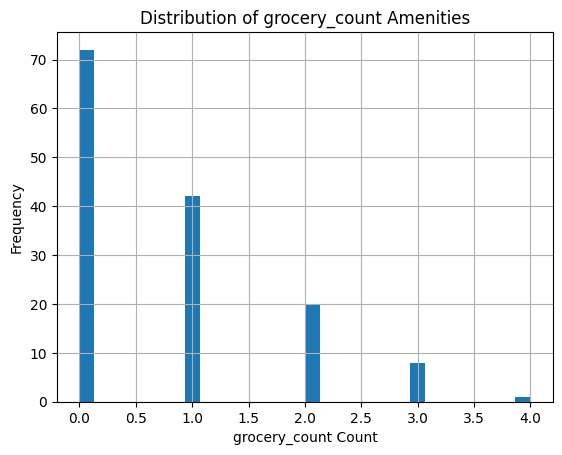

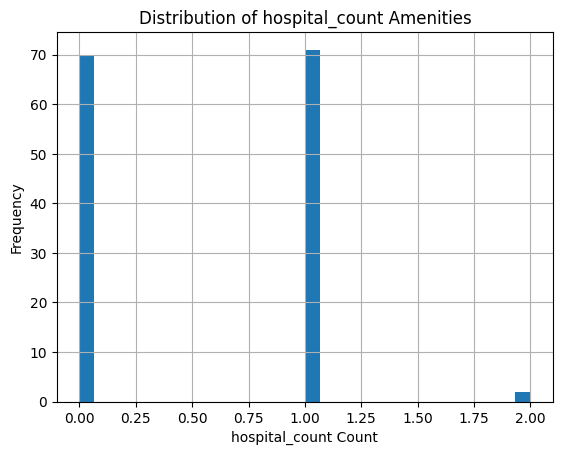

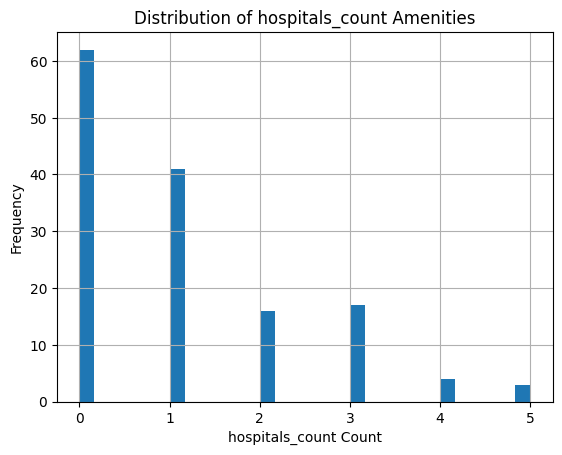

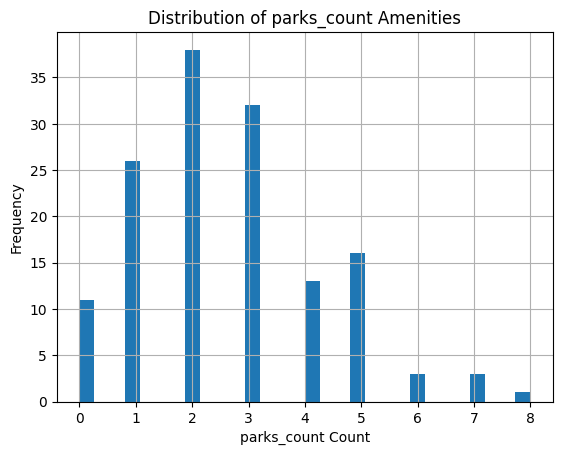

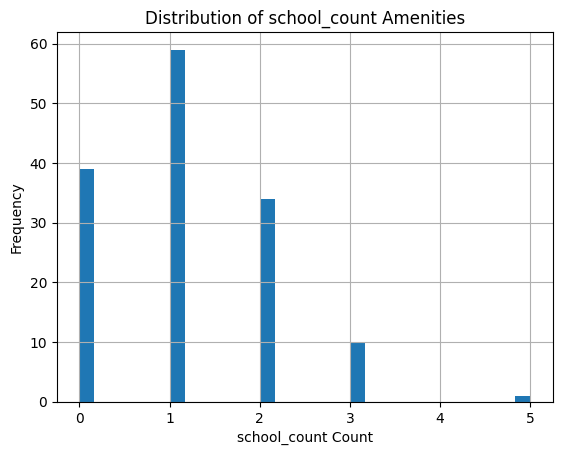

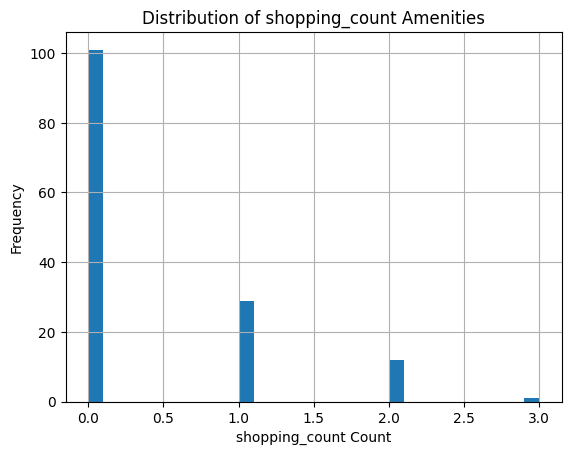

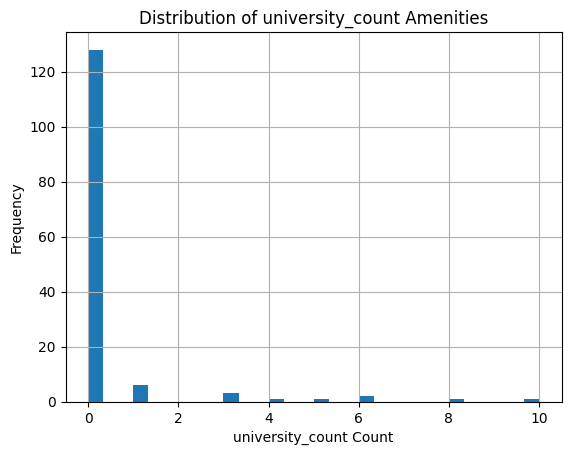

In [70]:
for i in range(len(x.columns) - 1):
    amenities = x.columns[i]
    df[amenities].hist(bins=30)
    plt.title(f"Distribution of {amenities} Amenities")
    plt.xlabel(f'{amenities} Count')
    plt.ylabel("Frequency")
    plt.show()